# *Ab* *initio* molecular dynamics of the vibrational motion of HF

### Part 1:  Analysis of an *ab* *initio* potential energy surfaces (PES)
We are going to construct what is often referred to as an ab initio potential energy surface of the
diatomic molecule hydrogen fluoride. We are going to use a reasonably good level of theory (CCSD/cc-pVTZ) to compute the electronic energy at different geometries of a simple diatomic molecule.  We will use Psi4's python interface to facilitate the electronic structure calculations, and then the interpolation capabilities of scipy to simplify the evalution of the potential energy at separations for which we did not explicitly evaluate the electronic energy. We will also use scipy to differentiate the interpolated potential energy surface to
obtain the forces acting on the atoms at different separations.

We will start by importing the necessary libraries:

In [1]:
import numpy as np
import psi4
from matplotlib import pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline

We will use a template for the z-matrix which will allow us to automate the specification of the
bond length of our HF molecule for easy computation of our potential energy surface.

In [2]:
# template for the z-matrix
mol_tmpl = """H
F 1 **R**"""

Now let’s create arrays for the bond length and energies at each bond length at the CCSD/cc-pVTZ level. 
Let’s have our bond lengths spane 0.5 - 2.3 Angstroms; note that
should use finer resolution for short bondlengths than our longer bondlengths because we want
to be sure we accurately represent the minimum energy point on the PES!

In [3]:
# array of bondlengths for HF
r_array = np.array([0.5, 0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3])
# empty array for the CCSD/cc-pVTZ energies
ccsd_energy_array = np.zeros_like(r_array)

In [4]:
# array for different instances of the HF molecule
molecules = []

# loop over the different bond-lengths, create different instances
# of HF molecule
for r in r_array:
    molecule = psi4.geometry(mol_tmpl.replace("**R**", str(r)))
    molecules.append(molecule)
    
# loop over instances of molecules, compute the RHF, MP2, and CCSD
# energies and store them in their respective arrays

energy_idx = 0
for mol in molecules:
    energy = psi4.energy("mp2/cc-pVDZ", molecule=mol)
    ccsd_energy_array[energy_idx] = energy
    energy_idx+=1



We can use matplotlib to plot the energies in the various arrays against the bondlengths in 'r_array':

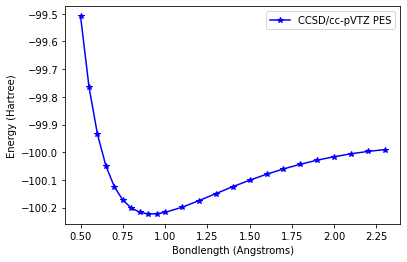

In [5]:
plt.plot(r_array, ccsd_energy_array, '-b*', label='CCSD/cc-pVTZ PES')
plt.xlabel("Bondlength (Angstroms)")
plt.ylabel("Energy (Hartree)")
plt.legend()
plt.show()

Now that you have the raw data, we will interpolate this data using cubic splines.  This will permit us to 
estimate the potential energy at any arbitrary separation between 0.5 and 2.3 Angstroms.

The general syntax for creating a cubic spline object is as follows:

`spline = InterpolatedUnivariateSpline(x-data, y-data, k=3)`

#### Note on units
The energies we used above are in a unit called Hartrees, which are the atomic unit of energy.  We have so far been specifying our separation in Angstroms (**not the atomic unit of length**) so we are in a mixed unit system.  When we generate our spline, we will use an array of bond lengths in atomic units as the x-data and the energies in atomic units as the y-data, which will yield a PES purely in atomic units.  Therefore, the first thing we will do before creating the spline is to create an array of bond lengths in atomic units called `r_array_au`, where (~1.89 * bond lengths in Angstroms is the bond length in atomic units). 

We will then create a cubic spline (called ccsd_energy_spline) that is a fit to the CCSD/cc-pVTZ energy as a function of bondlength in atomic units.

In [6]:
# !!! Create array of bond lengths in atomic units (r_array_au)
r_array_au = r_array * 1.89

# !!! create a cubic spline for the energies vs bond length in atomic units here (ccsd_energy_spline) 
ccsd_energy_spline = InterpolatedUnivariateSpline(r_array_au, ccsd_energy_array)

# !!! also create the negative of the energy spline, it will be useful for defining the force (negative_ccsd_energy_spline)
negative_ccsd_energy_spline = InterpolatedUnivariateSpline(r_array_au, -1 * ccsd_energy_array)


Now we can plot the splines against the PES data to make sure our splines were generated properly.

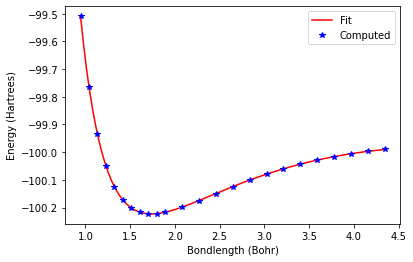

In [7]:
# form a much finer grid to evaluate spline object 
r_array_fine_au = np.linspace(0.5*1.89, 2.3*1.89, 200)

# compute the interpolated/extrapolated values for Energy on this grid
ccsd_energy_array_fine = ccsd_energy_spline(r_array_fine_au)


### plot the interpolated data with lines against computed data in *'s
plt.plot(r_array_fine_au, ccsd_energy_array_fine, 'red', label='Fit')
plt.plot(r_array_au, ccsd_energy_array, 'b*', label='Computed')
plt.xlabel("Bondlength (Bohr)")
plt.ylabel("Energy (Hartrees)")
plt.legend()
plt.show()


### Part 2:  Computation of Forces and related quantities and their importance in Newton's law
We can derive a number of important quantities just from the potential energy surfaces we have computed.  For example, we estimate the equilibrium bond length by finding the separation at which the potential is minimum; note this would also be the position that the force goes to zero:
\begin{equation}
\frac{d}{dr} V(r_{eq}) = -F(r_{eq}) = 0.
\end{equation}

The force as a function of separation plays a significant role in the vibrational motion of the molecule, as we will see shortly.  

To compute the force, we can use the fact
that the spline objects (which we previously created) can be directly differentiated using the following syntax:

`spline_derivative = spline.derivative()`

Once computed, plot each spline against the r_fine array previously created!
#### What unit system do you think the forces are in?

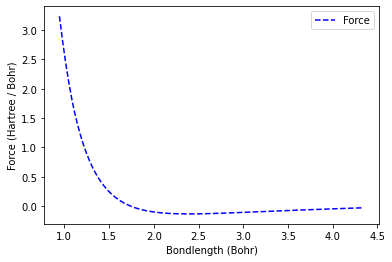

In [8]:
# !!! Differentiate splines and plot resulting forces in this cell (ccsd_force_spline)
ccsd_force_spline = negative_ccsd_energy_spline.derivative()

# !!! also get the *positive* first derivative of the energy spline (ccsd_energy_first_derivative_spline)
ccsd_energy_first_derivative_spline = ccsd_energy_spline.derivative()

# !!! define new array called (ccsd_force_array_fine)
ccsd_force_array_fine = ccsd_force_spline(r_array_fine_au)

# plot!
plt.plot(r_array_fine_au, ccsd_force_array_fine, 'b--', label='Force')
plt.xlabel("Bondlength (Bohr)")
plt.ylabel("Force (Hartree / Bohr)")
plt.legend()
plt.show()


#### Equilibrium bond length 
Next we will find where the minimum of the potential energy surfaces are and use that
to find the equilibrium bond length, making use of numpy's argmin function to find the
index corresponding to the minimum value in a numpy array:

In [9]:
# Find Equilibrium Bond-Lengths for each level of theory
r_eq_idx = np.argmin(ccsd_energy_array_fine)

# find the value of the separation corresponding to that index
ccsd_r_eq = r_array_fine_au[r_eq_idx]

# print equilibrium bond-lengths at each level of theory!
print(" Equilibrium bond lengt is ",ccsd_r_eq, "atomic units")
print(" Req is ",ccsd_r_eq / 1.89, "Angstroms")

# expected bondlength in Angstroms
expected_r_eq_angstroms = 0.9160804020100503

# just checking to make sure things are good so far!
assert np.isclose(ccsd_r_eq / 1.89, expected_r_eq_angstroms)


 Equilibrium bond lengt is  1.7313919597989949 atomic units
 Req is  0.9160804020100503 Angstroms


#### At this point, take a moment to compare your equilibrium bond length to the experimentally-determined (i.e. the "true" bond length) of HF.  You probably don't know the experimental bond length of HF off the top of your head, so look it up!

#### Harmonic Frequency 
You might have learned that the Harmonic Oscillator potential, which is a reasonable model for the vibrational motion of diatomic molecules near their equilibrium bond length, is given by
\begin{equation}
V(r) = \frac{1}{2} k (r-r_{eq})^2 + V_0
\end{equation}
and that the vibrational frequency of the molecule within the Harmonic oscillator model is given by
\begin{equation}
\nu = \frac{1}{2\pi}\sqrt{\frac{k}{\mu}}
\end{equation}
where $\mu$ is the reduced mass of the molecule and $k$ is known as the force constant.  
We can estimate the force constant as
\begin{equation}
k = \frac{d^2}{dr^2} V(r_{eq}),
\end{equation}
and the reduced mass of HF is defined as
\begin{equation}
\mu = \frac{m_H \cdot m_F}{m_H + m_F},
\end{equation}
where $m_H$ and $m_F$ are the masses of Hydrogen and Fluoride, respectively.

Let's go ahead and get the force constant and use it to estimate the vibrational frequency.
We will need to compute the reduced mass along the way! 
We can also estimate potential energy within the Harmonic approximation which we can plot against
the CCSD PES in a subsequent cell.  

Recall we differentiated the energy spline and stored it as the `ccsd_energy_first_derivative_spline`;
now we will differentiate that spline to get the `ccsd_curvature_spline`.


In [11]:
# mass of hydrogen in atomic units
mH = 1836.
### mass of fluorine in atomic units
mF = 34883.

# !!! compute reduced mass (mu)
mu = mH * mF / ( mH + mF )

# Print the reduced mass!
print("Reduced mass is ",mu, "atomic units")

# !!! Differentiate first derivative of energy spline to get curvatures (ccsd_curvature_spline)
ccsd_curvature_spline = ccsd_energy_first_derivative_spline.derivative()

# !!! Get force constant by evaluating ccsd_curvature_spline at r_eq_au (ccsd_k)
ccsd_k = ccsd_curvature_spline( ccsd_r_eq )

# Print the Force Constant
print("Force Constant is ", ccsd_k)

# !!! Compute the vibrational frequency (ccsd_nu)
ccsd_nu = 1 / (2 * np.pi) * np.sqrt( ccsd_k / mu )

# Print the frequency!
print("Frequency is ",ccsd_nu)

# This is the vibrational energy in atomic units in terms of the frequency
ccsd_omega = 2 * np.pi * ccsd_nu
print("Vibrational Energy is ",ccsd_omega, "atomic units")
print("Vibrational Energy is ",ccsd_omega * 27.211,"eV")


# expected reduced mass
expected_mu = 1744.1974999319154

# expected force constant
expected_k = 0.6472559836663361

# expected vibrational energy in eV
expected_energy_ev = 0.524185145363501

# test to see if any problems
assert np.isclose(mu, expected_mu)
assert np.isclose(ccsd_k, expected_k)
assert np.isclose(ccsd_omega * 27.211, expected_energy_ev)


Reduced mass is  1744.1974999319154 atomic units
Force Constant is  0.6472559836663361
Frequency is  0.0030659166138673664
Vibrational Energy is  0.019263722221289224 atomic units
Vibrational Energy is  0.524185145363501 eV


The vibrational energy in atomic units can be converted to more familiar 
spectroscopic units to allow comparision to the experimental vibrational frequency 
of HF.  For example, this [link](http://halas.rice.edu/conversions) has a very useful unit converter from energy to spectroscopic units like wavenumbers ($cm^{-1}$) or nanometers ($nm$).  It might be useful first to convert your vibrational energy in atomic units to electron volts by using the fact that 1 atomic unit of energy is equal to 27.211 electron volts.

Now that we have the force constants, let's define an array for the harmonic potential (`harmonic_potential_array`) that store the harmonic potentials at each level of theory evaluated at the different bond lengths (in atomic units) stored in the array r_fine; recall the definition of the Harmonic potential is 
\begin{equation}
V(r) = \frac{1}{2} k (r-r_{eq})^2 + V_0,
\end{equation}
where we can use $E(r_{eq})$ as $V_0$.

In [12]:
# !!! Create arrays storing V(r) along r_array_fine_au (harmonic_potential_array)
harmonic_potential_array = 0.5 * ccsd_k * (r_array_fine_au - ccsd_r_eq) ** 2 + ccsd_energy_spline(ccsd_r_eq)


Let's plot the resulting Harmonic potential against the *ab* *initio* potential near the equilibrium geometry

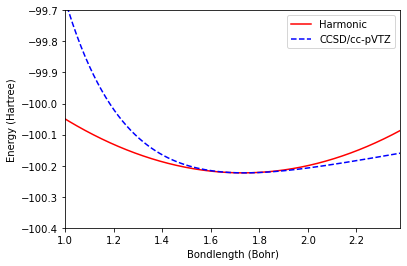

In [13]:
### plot RHF harmonic potential vs RHF ab initio potential!
plt.plot(r_array_fine_au, harmonic_potential_array, 'red', label='Harmonic')
plt.plot(r_array_fine_au, ccsd_energy_array_fine, 'b--', label='CCSD/cc-pVTZ' )
plt.xlabel("Bondlength (Bohr)")
plt.ylabel("Energy (Hartree)")
# these limits were chosen to zoom in on region of the RHF PES that is approximately
# harmonic... can anyone suggest a better way to make a plot that is zoomable?
plt.xlim(1.0, (1.69+0.69))
plt.ylim(-100.4,-99.7)
plt.legend()
plt.show()

### Part 3: Solving Newton's equation of motion to simulate the dynamics
Next, we want to actually simulate the dynamics of the HF molecule on these *ab* *initio* potential energy surfaces.  To do so, we need to solve Newton's equations of motion subject to some initial condition for the position (separation) and momentum (in a relative sense) of the particles.  Newton's equations can be written
\begin{equation}
F(r) = \mu \frac{d^2}{dr^2}
\end{equation}
where $\mu$ is the reduced mass in atomic units and $F(r)$ is the Force vs separation in atomic units that was determined previously.  

#### What will be the accelation of the bond stretch when H is separated by F by 3 atomic units?  You can express your acceleration in atomic units and store to the variable `test_acceleration`



In [16]:
# !!! Compute acceleration at CCSD level when HF is displaced by 3 atomic units (test_acceleration) """
test_acceleration = ccsd_force_spline(3) / mu

# expected value - just to check things!
expected_acceleration = -6.255740091785719e-05
assert np.isclose(test_acceleration, expected_acceleration)

-6.255740091785719e-05


#### Numerically solving Newton's equation of motion 
If the acceleration, position, and velocity of the bond stretch coordinate are known at some instant in 
time $t_i$, then the position and velocity can be estimated at some later time $t_{i+1} = t_i + \Delta t$:
\begin{equation}
r(t_i + \Delta t) = r(t_i) + v(t_i)\Delta t + \frac{1}{2}a(t_i)\Delta t^2
\end{equation}
and
\begin{equation}
v(t_i + \Delta t) = v(t_i) + \frac{1}{2} \left(a(t_i) + a(t_i + \Delta t)  \right) \Delta t.
\end{equation}
This prescription for updating the velocities and positions is known as the Velocity-Verlet algorithm.  
Note that we need to perform 2 force evaluations per Velocity-Verlet iteration: one corresponding
to position $r(t_i)$ to update the position, and then a second time at the updated position $r(t_i + \Delta t)$
to complete the velocity update.  

We will create a function called Velocity_Verlet that takes the arguments r_curr, v_curr, mu, force_spline, and timestep and returns a 2-element array containing the updated position (r) and velocity (v) value.

In [17]:
''' Velocity Verlet function goes in this cell! '''
def velocity_verlet(r_curr, v_curr, mu, force_spline, dt):

    # !!! get acceleration at time t_i (a_curr)
    a_curr = force_spline(r_curr) / mu

    # !!! update r (r_new)
    r_new = r_curr + v_curr * dt + 0.5 * a_curr * dt * dt

    # !!! get acceleration at time t_i+dt based on r_new (a_new)
    a_new = force_spline(r_new) / mu

    # !!! update velocity (v_new)
    v_new = v_curr + 0.5 * (a_curr + a_new) * dt
    
    # return r_new and v_new
    return r_new, v_new

    

### Validating Velocity-Verlet algorithm with the Harmonic Oscillator
Newton's equation of motion can be solved analytically for the Harmonic oscillator, and we can use this fact to validate our Velocity-Verlet algorithm (which provides an *approximate* solution to Newton's equation of motion for arbitrary potentials).  That is,
the vibrational motion of a diatomic subject to a Harmonic potential predicted 
by the Velocity-Verlet algorithm should closely match the analytical solution. Analytically, 
the bond length as a function of time for a diatomic experiencing a harmonic potential is given by
\begin{equation}
r(t) = A \: {\rm sin}\left(\sqrt{\frac{k}{\mu}} t + \phi \right) + r_{eq},
\end{equation}
where $A = \frac{r(0)}{{\rm sin}(\phi)}$, $r(0)$ is the initial separation, and $\phi$ is the initial phase of the cycle; note that corresponding to this initial separation is 
an initial velocity given by 
\begin{equation}
v(0) = A \: \sqrt{\frac{k}{\mu}} {\rm cos}\left( \phi \right).
\end{equation}

Let's define a function harmonic_position that takes arguments of $\sqrt{\frac{k}{\mu}}$ (om), $A$ (amp), $\phi$ (phase), $r_{eq}$ (req), and time (t), and returns the separation. 


In [18]:
''' Analytic solution to Harmonic Oscillator r(t) goes here! '''
def harmonic_position(om, amp, phase, req, t):
    # !!! this function will compute and return r(t)
    return amp * np.sin(om * t + phase) + req
    

The following code block will call the Velocity Verlet algorithm 10,000 times with a 
timestep of 0.1 atomic units per timestep and will compare the resulting trajectory of bond length vs time (all in atomic units) to the analytic result for the Harmonic oscillator; we will initiate the bond length as being 0.2 atomic units **longer** than $r_{eq}$ with an initial phase of $\frac{\pi}{4}$.

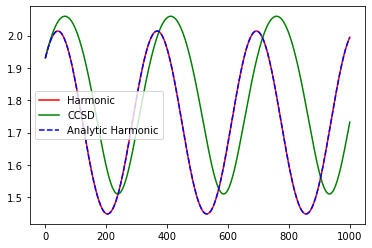

In [19]:
# how many updates do you want to perform?
n_steps = 10000

# establish time-step for integration to be 0.02 atomic units... this is about 0.0005 femtoseconds
# so total time is 200000*0.02 atomic units of time which is ~9.6e-13 s, or 960 fs
dt = 0.1

# arrays to store results from VV algorithm

# using Harmonic fit to ab initio potential
harmonic_r_vs_t = np.zeros(n_steps)
harmonic_v_vs_t = np.zeros(n_steps)

# using spline fit to ab initio potential
ccsd_r_vs_t = np.zeros(n_steps) 
ccsd_v_vs_t = np.zeros(n_steps)

# array to store analytic result for r(t) using the Harmonic fit to the potential
analytic_r_vs_t = np.zeros(n_steps)

# array to store time in atomic units
t_array = np.zeros(n_steps)

# establish some constants relevant for analytic solution, some choices arbitrary
# initial displacement 
x0 = 0.2

# amplitude for analytic solution
amplitude = x0 / ( np.sin( np.pi / 4) )

# initial velocity
v0 = amplitude * ccsd_omega * np.cos( np.pi / 4 )

# initial conditions same for harmonic and ab initio solutions
harmonic_r_vs_t[0] = ccsd_r_eq + x0
harmonic_v_vs_t[0] = v0

ccsd_r_vs_t[0] = ccsd_r_eq + x0
ccsd_v_vs_t[0] = v0

analytic_r_vs_t[0] = ccsd_r_eq + x0

# spline for Harmonic potential using ccsd_k
negative_harmonic_potential_spline = InterpolatedUnivariateSpline(r_array_fine_au, -1 * harmonic_potential_array, k=3)
# ccsd harmonic force spine
harmonic_force_spline = negative_harmonic_potential_spline.derivative()


# iterate through n_steps and update position and velocity
for i in range(1, n_steps):

    # store current time
    t_array[i] = dt*i

    # Compute VV update using ab initio Force
    ccsd_r_vs_t[i], ccsd_v_vs_t[i] =  velocity_verlet(ccsd_r_vs_t[i-1], ccsd_v_vs_t[i-1], mu, ccsd_force_spline, dt)

    # Compute VV update using Harmonic model Force
    harmonic_r_vs_t[i], harmonic_v_vs_t[i] = velocity_verlet(harmonic_r_vs_t[i-1], harmonic_v_vs_t[i-1], mu, harmonic_force_spline, dt)

    # analytical update
    analytic_r_vs_t[i] = harmonic_position(ccsd_omega, amplitude, np.pi / 4, ccsd_r_eq, dt * i)

# Plot result and compare!
plt.plot(t_array, harmonic_r_vs_t, 'red', label="Harmonic")
plt.plot(t_array, ccsd_r_vs_t, 'green', label="CCSD")
plt.plot(t_array, analytic_r_vs_t, 'b--', label="Analytic Harmonic")
plt.legend()
plt.show()

# check to see if the harmonic velocity verlet agrees closely with the analytical solution
assert np.allclose(harmonic_r_vs_t, analytic_r_vs_t)

#### How are the dynamics different when the *ab* *initio* forces are used?  Try to identify at least two quantitative ways in which you can distinguish the harmonic motion from the motion deriving from the *ab* *initio* forces.  

#### Can you estimate the frequency from the *ab* *initio* trajectories?  How does this frequency compare with the Harmonic approximation and with the experimental value?

### For further consideration: What makes a "sensible range of values" for position and velocity?

In this case, we will initialize the position to be a random number between 1.0 and 4.0; for the velocity, we will use the fact that we can estimate the expectation value of kinetic energy for a very similar system (the Harmonic oscillator) in the ground state as follows:
\begin{equation}
\langle T \rangle = \frac{1}{2} E_g,
\end{equation}
where $E_g$ is the ground state of the Harmonic oscillator (this is making use of the Virial theorem).  We can easily
find the ground state energy in the Harmonic oscillator approximation of $HF$ using our frequency calculation described above as
\begin{equation}
E_g = \frac{1}{2} h \nu,
\end{equation}
which implies the kinetic energy expectation value is
\begin{equation}
\langle T \rangle = \frac{h}{8 \pi} \sqrt{\frac{k}{\mu}}.
\end{equation}
Since we can say classically that the kinetic energy is given by $T = \frac{1}{2}\mu v^2$, we can estimate the velocity of the bond stretch as follows:
\begin{equation}
v = \sqrt{\frac{2 \langle T \rangle}{\mu}} = \sqrt{ \frac{\hbar \sqrt{\frac{k}{\mu}}}{2\mu}}
\end{equation}
where we have simplified using the fact that $\hbar = \frac{h}{2\pi}$ ($\hbar$ has the value 1 in the atomic unit system we are using up to this point!).  We will assume that a reasonable
range of velocities spans plus or minus 3 times this "ground-state" velocity.
